In [1]:
import category_encoders as ce
import community as community_louvain
import networkx as nx
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.auto import tqdm


/opt/anaconda/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_test = pd.read_csv("test_data/fraudTest.csv", index_col=0)
df = pd.read_csv("test_data/fraudTrain.csv", index_col=0)

In [3]:
df = pd.concat([df, df_test])

In [4]:
df.shape

(1852394, 22)

In [5]:
def initial_data_process(df):
    # Приведение типов данных к datetime
    df["trans_date_trans_time"] = pd.to_datetime(
        df["trans_date_trans_time"], errors="coerce"
    )
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

    # Функция для вычисления расстояния между точками
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = np.radians(lat2 - lat1)
        dlambda = np.radians(lon2 - lon1)
        a = (
            np.sin(dphi / 2) ** 2
            + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
        )
        return 2 * R * np.arcsin(np.sqrt(a))

    # Извлечение базовых временных признаков
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["dayofweek"] = df["trans_date_trans_time"].dt.day_name()
    df["month"] = df["trans_date_trans_time"].dt.month

    # Получение расстояния между клиентом и магазином
    df["distance_km"] = haversine(
        df["lat"], df["long"], df["merch_lat"], df["merch_long"]
    )

    # Возраст клиента на момент транзакции на основе даты рождения
    df["age"] = df.apply(
        lambda row: row["trans_date_trans_time"].year
        - row["dob"].year
        - (
            (row["trans_date_trans_time"].month, row["trans_date_trans_time"].day)
            < (row["dob"].month, row["dob"].day)
        ),
        axis=1,
    )

    return df


df = initial_data_process(df)

# EDA

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
print("Shape:", df.shape)
print("Data types:\n", df.dtypes)

Shape: (1852394, 27)
Data types:
 trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
hour                              int32
dayofweek                        object
month 

In [8]:
print("Missing values per column:\n", df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())

Missing values per column:
 trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
hour                     0
dayofweek                0
month                    0
distance_km              0
age                      0
dtype: int64
Duplicate rows: 0


In [9]:
df.describe()

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,hour,month,distance_km,age
count,1852394,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1852394,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,2020-01-20 21:31:46.801827328,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1973-10-15 11:05:05.744458256,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,1.280612e+01,7.152067e+00,7.611173e+01,4.576496e+01
min,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1924-10-30 00:00:00,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.225452e-02,1.300000e+01
25%,2019-07-23 04:13:43.750000128,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1962-08-13 00:00:00,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,7.000000e+00,4.000000e+00,5.532009e+01,3.200000e+01
50%,2020-01-02 01:15:31,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1975-11-30 00:00:00,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,1.400000e+01,7.000000e+00,7.821638e+01,4.400000e+01
75%,2020-07-23 12:11:25.249999872,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1987-04-23 00:00:00,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,1.900000e+01,1.000000e+01,9.850947e+01,5.700000e+01
max,2020-12-31 23:59:34,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,2005-01-29 00:00:00,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,2.300000e+01,1.200000e+01,1.521172e+02,9.600000e+01
std,NaN,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,NaN,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,6.815753e+00,3.424954e+00,2.911697e+01,1.741240e+01


## Сумма транзакций

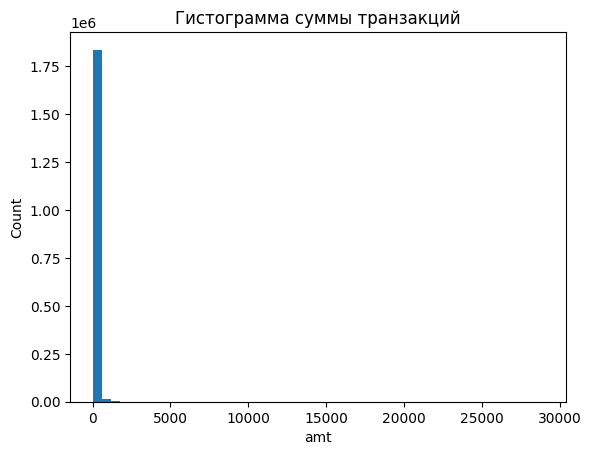

In [10]:
plt.figure()
plt.hist(df["amt"].dropna(), bins=50)
plt.title("Гистограмма суммы транзакций")
plt.xlabel("amt")
plt.ylabel("Count")
plt.show()

In [11]:
df[df["amt"] > 1500]["is_fraud"].value_counts()

is_fraud
0    1903
Name: count, dtype: int64

Видим, что у гистограммы транзакций очень большой хвост, при этом мошеннических транзакций там нет. Удалим все строки, в которых сумма транзакции > 1500, так как они составляют 0.1% от общего числа записей. При разработке системы начиная с некоторого порога можно будет помечать транзакции как подозрительные, но при обучении алгоритма эти данные бесполезны.

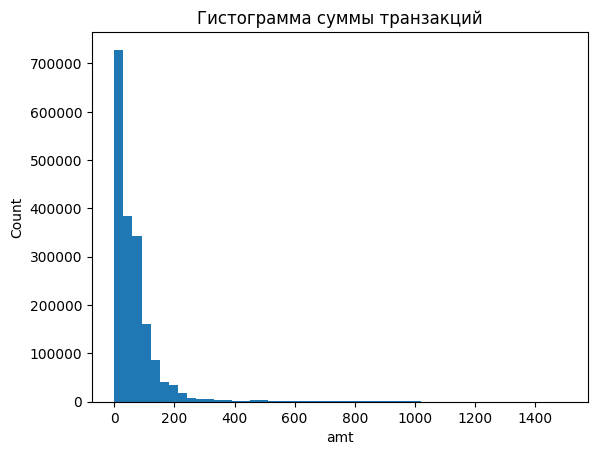

In [12]:
df = df[df["amt"] < 1500]
plt.figure()
plt.hist(df["amt"].dropna(), bins=50)
plt.title("Гистограмма суммы транзакций")
plt.xlabel("amt")
plt.ylabel("Count")
plt.show()

## Категориальные признаки

In [13]:
cat_cols = ["category", "merchant", "state", "job", "gender"]
full_fraud = {}
for col in cat_cols:
    print(f"\nЧастота значений по {col}:")
    print(df[col].value_counts().head(10))
    print("-" * 50)

    fraud_ratio = (
        df.groupby(col)["is_fraud"].mean().sort_values(ascending=False).head(20)
    )
    if any(fraud_ratio == 1):
        full_fraud[col] = fraud_ratio[fraud_ratio == 1].index.tolist()
    print(f"Доля мошенничества для топ-10 по {col}:")
    print(fraud_ratio)
    print("-" * 100)


Частота значений по category:
category
gas_transport     188029
grocery_pos       176191
home              175460
shopping_pos      165756
kids_pets         161727
shopping_net      138816
entertainment     134118
food_dining       130729
personal_care     130085
health_fitness    122553
Name: count, dtype: int64
--------------------------------------------------
Доля мошенничества для топ-10 по category:
category
shopping_net      0.015985
misc_net          0.013048
grocery_pos       0.012645
shopping_pos      0.006371
gas_transport     0.004106
misc_pos          0.002821
travel            0.002717
grocery_net       0.002697
personal_care     0.002229
entertainment     0.002177
kids_pets         0.001880
food_dining       0.001568
home              0.001510
health_fitness    0.001510
Name: is_fraud, dtype: float64
----------------------------------------------------------------------------------------------------

Частота значений по merchant:
merchant
fraud_Kilback LLC        6262
f

In [14]:
print(full_fraud)
total_fraud_in_data = df["is_fraud"].sum()
total = 0
for category, values in full_fraud.items():
    print(f"\nCategory: {category}")
    for value in values:
        count = (df[category] == value).sum()
        fraud_count = df[(df[category] == value) & (df["is_fraud"] == 1)].shape[0]
        total += fraud_count
        print(f"  {value}: {count} occurrences")
    print(f"Total fraud count for {category}: {total}")
    print(f"Fraud percentage for {category}: {total / total_fraud_in_data:.2%}")
    print("-" * 100)


{'state': ['DE'], 'job': ['Air traffic controller', 'Careers adviser', 'Broadcast journalist', 'Armed forces technical officer', 'Contracting civil engineer', 'Sales promotion account executive', 'Ship broker', 'Software engineer', 'Solicitor', 'Dancer', 'Legal secretary', 'Accountant, chartered', 'Veterinary surgeon', 'Engineer, water', 'Engineer, site', 'Operational investment banker', 'Personnel officer', 'Forest/woodland manager', 'Homeopath', 'Industrial buyer']}

Category: state
  DE: 9 occurrences
Total fraud count for state: 9
Fraud percentage for state: 0.09%
----------------------------------------------------------------------------------------------------

Category: job
  Air traffic controller: 17 occurrences
  Careers adviser: 15 occurrences
  Broadcast journalist: 9 occurrences
  Armed forces technical officer: 8 occurrences
  Contracting civil engineer: 7 occurrences
  Sales promotion account executive: 14 occurrences
  Ship broker: 7 occurrences
  Software engineer: 11

Видно, что есть категории, в некоторых значений которых все записи являются мошенническими. Очевидным решением было бы исключить эти записи, но в данном наборе данных записи связаны как, так как один и тот же клиент появляется в наборе данных более 1-го раза, как и каждый магазин, формируя историю взаимодействий. С этими значениями будем бороться с помощью параметра `smoothing` в TargetEncoder

## Расстояние

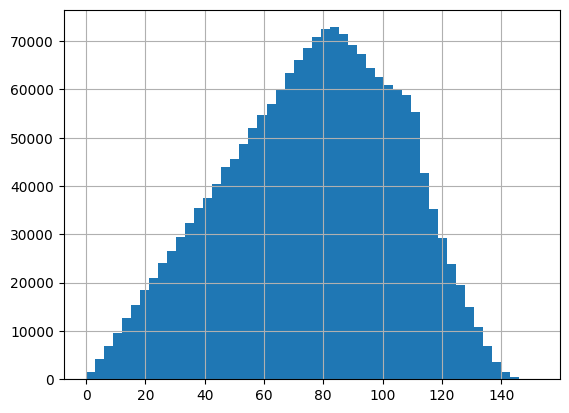

In [15]:
df["distance_km"].hist(bins=50)
plt.show()

С расстоянием все почти нормально (🙂)

## Возраст

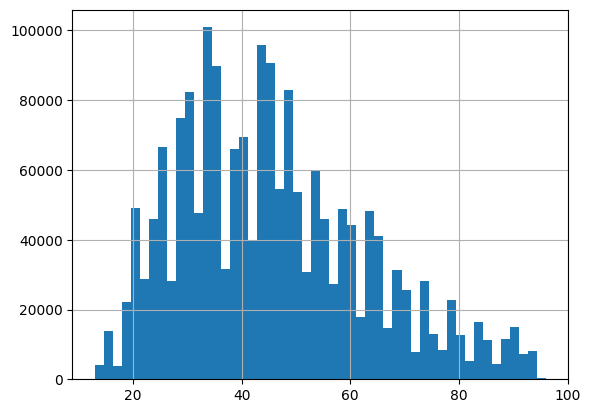

In [16]:
df["age"].hist(bins=50)
plt.show()

In [17]:
df["age"].value_counts().sort_index(ascending=False).head(20)

age
96       77
95      357
94     2560
93     5571
92     7181
91     7760
90     7112
89     6489
88     4982
87     4239
86     4842
85     6393
84     8545
83     7932
82     5183
81     4843
80     7801
79    10134
78    12452
77     8393
Name: count, dtype: int64

Возможно, некоторые возрасты великоваты, но жить можно

## Корреляция признаков

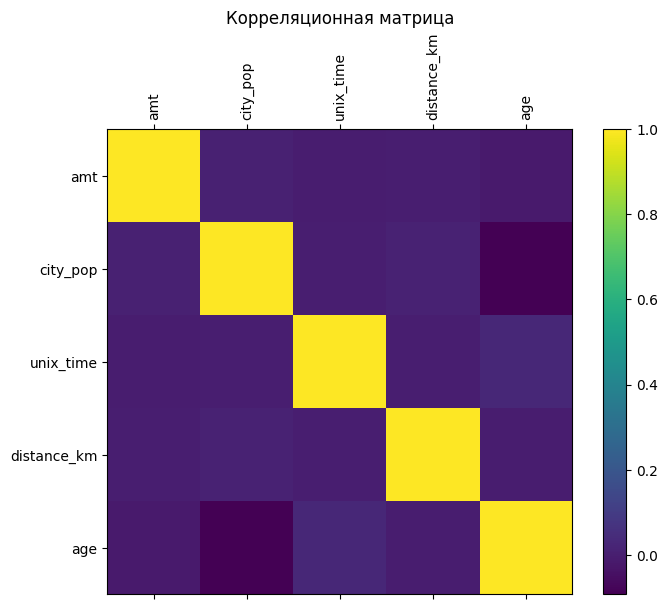

In [18]:
corr_cols = ["amt", "city_pop", "unix_time", "distance_km", "age"]
corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
plt.matshow(corr, fignum=1)
plt.title("Корреляционная матрица")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.show()


## Дизбаланс классов

In [19]:
df["is_fraud"].value_counts(normalize=True)

is_fraud
0    0.994785
1    0.005215
Name: proportion, dtype: float64

# Feature engeneering и обработка данных

Добавим временные фичи, а именно:
1. Час
2. День недели
3. Месяц
4. Флаг ночного времени
5. Флаг рабочих часов
6. Флаг выходных
7. Разницу во времени между текущей и предыдущей транзакцией


Последнию фичу для теста будем рассчитывать с учетом тренировочных данных, так как тест - продолженией трейна во времени

In [20]:
def add_time_and_amount_features(
    df_train: pd.DataFrame, roll_windows: list[int] = [5]
) -> pd.DataFrame:
    # 0. Рабочая копия
    train = df_train.copy()

    # 1. Базовые временные признаки
    train["hour"] = train["trans_date_trans_time"].dt.hour
    train["dayofweek"] = train["trans_date_trans_time"].dt.day_name()
    train["month"] = train["trans_date_trans_time"].dt.month
    train["is_night"] = ((train["hour"] < 6) | (train["hour"] > 20)).astype(int)
    train["is_business_hour"] = ((train["hour"] >= 9) & (train["hour"] <= 18)).astype(
        int
    )
    train["is_weekend"] = train["dayofweek"].isin(["Saturday", "Sunday"]).astype(int)

    # 2. Временные дельты
    train = train.sort_values(["cc_num", "trans_date_trans_time"])
    train["prev_time"] = train.groupby("cc_num")["trans_date_trans_time"].shift()
    train["time_diff_h"] = (
        train["trans_date_trans_time"] - train["prev_time"]
    ).dt.total_seconds() / 3600
    # явно заполняем NaN
    median_td = train["time_diff_h"].median()
    train["time_diff_h"] = train["time_diff_h"].fillna(median_td)

    # 3. Признаки по суммам
    amt_col = "amt"
    train["prev_amount"] = train.groupby("cc_num")[amt_col].shift()
    train["amount_diff"] = train[amt_col] - train["prev_amount"]
    train["amount_diff"] = train["amount_diff"].fillna(0)
    train["amount_ratio"] = train[amt_col] / train["prev_amount"].replace(0, 1)

    # 3.1 Скользящие mean/std через transform
    for w in roll_windows:
        train[f"roll_mean_amt_{w}"] = train.groupby("cc_num")[amt_col].transform(
            lambda s: s.shift().rolling(window=w, min_periods=1).mean()
        )
        train[f"roll_std_amt_{w}"] = train.groupby("cc_num")[amt_col].transform(
            lambda s: s.shift().rolling(window=w, min_periods=1).std().fillna(0)
        )

    # 4. Признак "уникальных" магазинов за 30 дней
    #    перекодируем merchant в цифры
    train["merchant_code"] = train["merchant"].astype("category").cat.codes
    train = train.set_index("trans_date_trans_time")
    train["unique_merch_last_30d"] = (
        train.groupby("cc_num")["merchant_code"]
        .apply(
            lambda s: s.shift().rolling("30d").apply(lambda x: len(set(x)), raw=False)
        )
        .reset_index(level=0, drop=True)
    )
    train = train.reset_index()

    # 5. Финальные чистки
    train = train.drop(columns=["merchant_code"])
    train = train.fillna(0)

    return train


df = add_time_and_amount_features(df)

In [21]:
df["gender"] = df["gender"].map({"M": 0, "F": 1})


Ниже - класс для обработки данных. Он может работать как с графовыми фичами, так и без них.
Он реализует нормализацию числовых признаков, OHE для фичей с низкой кардинальностью и TE для фичей с высокой кардинальностью, а также изменяет баланс классов в обучающей выборке, так как данные очень несбалансированы.

In [22]:
from typing import List, Tuple, Union

ALL_USED_COLUMNS = []
training_df = pd.DataFrame()
test_df = pd.DataFrame()
TARGET_FRAC = 0.001


class FraudDataPreprocessor:
    def __init__(
        self, graph_features: bool = False, random_state: int = 42, gnn_prepare=False
    ):
        """
        Parameters:
        - graph_features: whether to include graph-based numeric features
        - random_state: seed for reproducibility
        """
        self.graph_features = graph_features
        self.random_state = random_state
        self.gnn_prepare = gnn_prepare

        self.numeric_features: List[str] = []
        self.low_cardinal_feats: List[str] = []
        self.high_cardinal_feats: List[str] = []
        self.as_is_cols: List[str] = []
        self.low_ohe_cols: List[str] = []

        self.scaler: StandardScaler = None
        self.ohe: OneHotEncoder = None
        self.target_encoder: ce.TargetEncoder = None

    def fit(self, df: pd.DataFrame, y: pd.Series, n_splits: int = 5):
        numeric = [
            "amt",
            "city_pop",
            "distance_km",
            "age",
            "time_diff_h",
            "prev_amount",
            "amount_diff",
            "amount_ratio",
            "roll_mean_amt_5",
            "roll_std_amt_5",
            "unique_merch_last_30d",
        ]

        low_card = [
            "category",
            "dayofweek",
            "hour",
            "month",
        ]

        high_card = [
            "job",
            "state",
        ]

        as_is_feats = [
            "gender",
            "is_weekend",
            "is_business_hour",
            "is_night",
        ]

        if self.graph_features:
            numeric += ["c_deg", "c_comm_size", "m_deg", "m_comm_size"]
            high_card += ["c_comm", "m_comm"]
            as_is_feats += [c for c in df.columns if c.startswith("emb_")]

        if self.gnn_prepare:
            as_is_feats += ["cc_num", "merchant"]

        self.numeric_features = numeric
        self.low_cardinal_feats = low_card
        self.high_cardinal_feats = high_card
        self.as_is_cols = as_is_feats

        self.scaler = StandardScaler().fit(df[self.numeric_features])

        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.ohe.fit(df[self.low_cardinal_feats])
        self.low_ohe_cols = self.ohe.get_feature_names_out(
            self.low_cardinal_feats
        ).tolist()

        self.target_encoder = ce.TargetEncoder(
            cols=self.high_cardinal_feats,
            smoothing=0.4,  # позволяет избежать "запоминания", когда для некоторого класса все примеры имеют одинаковое значение
        ).fit(df[self.high_cardinal_feats], y)

        return self

    def transform(
        self, df: pd.DataFrame
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        if any(obj is None for obj in (self.scaler, self.ohe, self.target_encoder)):
            raise RuntimeError("Run .fit() first")

        has_target = "is_fraud" in df.columns
        if has_target:
            y = df["is_fraud"].to_numpy()
            df = df.drop(columns="is_fraud")
        else:
            y = None

        X_as_is = df[self.as_is_cols].to_numpy() if self.as_is_cols else None

        X_num = self.scaler.transform(df[self.numeric_features])
        X_low = self.ohe.transform(df[self.low_cardinal_feats])
        X_high = self.target_encoder.transform(df[self.high_cardinal_feats]).values

        arrays = [X_num, X_low, X_high]
        if X_as_is is not None:
            arrays.append(X_as_is)

        X = np.hstack(arrays)

        return (X, y) if has_target else X

    def fit_transform(
        self, df: pd.DataFrame, test_size: float = 0.2
    ) -> Tuple[np.ndarray, np.ndarray, pd.Series, pd.Series]:
        y = df["is_fraud"]
        X = df.drop(columns=["is_fraud"])
        X_train, X_val, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=self.random_state
        )

        self.fit(X_train, y_train)

        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        X_train_high_oof = pd.DataFrame(
            index=X_train.index, columns=self.high_cardinal_feats, dtype=float
        )
        for col in self.high_cardinal_feats:
            for tr_idx, val_idx in kf.split(X_train):
                te = ce.TargetEncoder(
                    cols=[col], smoothing=0.4
                )  # позволяет избежать "запоминания", когда для некоторого класса все примеры имеют одинаковое значение
                te.fit(X_train.iloc[tr_idx][[col]], y_train.iloc[tr_idx])
                X_train_high_oof.iloc[
                    val_idx, X_train_high_oof.columns.get_loc(col)
                ] = te.transform(X_train.iloc[val_idx][[col]])[col]

        X_train_proc = np.hstack(
            [
                self.scaler.transform(X_train[self.numeric_features]),
                self.ohe.transform(X_train[self.low_cardinal_feats]),
                X_train_high_oof.values,
                (
                    X_train[self.as_is_cols].to_numpy()
                    if self.as_is_cols
                    else np.empty((len(X_train), 0))
                ),
            ]
        )
        X_test_proc = self.transform(X_val)

        pos_mask = y_train.values == 1
        n_pos = pos_mask.sum()
        n_neg_needed = int(np.floor(n_pos * (1 - TARGET_FRAC) / TARGET_FRAC))
        neg_mask = ~pos_mask

        global ALL_USED_COLUMNS, training_df, test_df
        ALL_USED_COLUMNS = (
            self.numeric_features
            + self.low_ohe_cols
            + self.high_cardinal_feats
            + self.as_is_cols
        )
        training_df = pd.DataFrame(X_train_proc, columns=ALL_USED_COLUMNS)
        test_df = pd.DataFrame(X_test_proc, columns=ALL_USED_COLUMNS)

        if neg_mask.sum() > n_neg_needed:
            rng = np.random.RandomState(self.random_state)
            neg_indices = np.where(neg_mask)[0]
            sampled_neg = rng.choice(neg_indices, size=n_neg_needed, replace=False)
            keep = np.concatenate([np.where(pos_mask)[0], sampled_neg])
            X_train_proc = X_train_proc[keep]
            y_train = y_train.iloc[keep]

        return X_train_proc, X_test_proc, y_train, y_test

In [23]:
df.shape

(1850491, 38)

In [24]:
prep = FraudDataPreprocessor(graph_features=False)
X_train_processed, X_test_processed, y_train, y_test = prep.fit_transform(df)


## Graph features generating

При генерации графовых фичей для тестового набора данных в качестве базового графа будет использован граф данных с тренировочной выборки, так как тестовые данные - продолжение тренировочных исходя из метки времени с теми же клиентами и мерчантами. </br>
В качестве графовых фичей используется метка сообщества, размер сообщества, степень узла. Были попытки использовать и другие, такие как PageRank, betweenness, но они были сильно скоррелированы со степенью узла, поэтому было решено оставить только ее.

In [25]:
import pandas as pd


def generate_graph_features(
    df: pd.DataFrame, base_graph: nx.Graph | None = None
) -> tuple[pd.DataFrame, nx.Graph]:
    G = base_graph.copy() if base_graph is not None else nx.Graph()

    clients = df["cc_num"].unique()
    merchants = df["merchant"].unique()
    G.add_nodes_from(clients, bipartite=0)
    G.add_nodes_from(merchants, bipartite=1)

    edges = list(zip(df["cc_num"], df["merchant"]))
    for u, v in tqdm(edges, desc="Adding edges"):
        G.add_edge(u, v)

    degree = dict(G.degree())
    partition = community_louvain.best_partition(G)
    sizes = pd.Series(partition).value_counts().to_dict()

    node_df = pd.DataFrame(
        {
            "node": list(degree.keys()),
            "degree": list(degree.values()),
            "community": [partition[n] for n in degree],
        }
    )
    node_df["comm_size"] = node_df["community"].map(sizes)

    df_clients = node_df[node_df["node"].isin(clients)].rename(
        columns={
            "node": "cc_num",
            "degree": "c_deg",
            "community": "c_comm",
            "comm_size": "c_comm_size",
        }
    )
    df_merch = node_df[node_df["node"].isin(merchants)].rename(
        columns={
            "node": "merchant",
            "degree": "m_deg",
            "community": "m_comm",
            "comm_size": "m_comm_size",
        }
    )

    df_feat = df.merge(df_clients, on="cc_num", how="left").merge(
        df_merch, on="merchant", how="left"
    )

    return df_feat, G


df_feat, G_feat = generate_graph_features(df)


Adding edges: 100%|██████████| 1850491/1850491 [00:01<00:00, 1059784.25it/s]


Проверим, как много "конфликтных" пар (пар, у которых есть как мошеннические, так и не мошеннические транзакции)

In [26]:
# 1. Собираем статистику по каждой паре
df_pairs = (
    df_feat.groupby(["cc_num", "merchant"])  # группируем по карте и магазину
    .agg(
        txn_count=("is_fraud", "size"),  # общее число транзакций
        n_labels=("is_fraud", "nunique"),  # сколько уникальных значений метки
        fraud_types=(
            "is_fraud",
            lambda s: set(s),
        ),  # набор встреченных меток {0}, {1} или {0,1}
    )
    .reset_index()
)

# 2. Отбираем только те пары, где транзакций больше одной и меток 2 (т.е. есть и 0, и 1)
contradictory = df_pairs[(df_pairs["txn_count"] > 1) & (df_pairs["n_labels"] > 1)]

# 3. Смотрим результат
total_txns = len(df_feat)
conflict_txns = df_feat.merge(
    contradictory[["cc_num", "merchant"]], on=["cc_num", "merchant"], how="inner"
).shape[0]

print(f"Всего транзакций: {total_txns:,}")
print(f"Транзакций в конфликтных парах: {conflict_txns:,}")
print(f"Доля конфликтных: {conflict_txns / total_txns:.2%}")

Всего транзакций: 1,850,491
Транзакций в конфликтных парах: 35,640
Доля конфликтных: 1.93%


Видно, что таких много, значит не получится использовать подход по предсказанию на чистых эмбеддингах, потому что для одного и того же входа будет 2 варианта выхода, это противоречие. Попробуем использовать эти фичи простым присоединением, а также позднее попробуем использовать графовую нейронную сеть

In [27]:
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx

EMBEDDINGS_DIMENSION = 64
DEVICE = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")


def get_graph_embeddings(df_feat, G):
    data = from_networkx(G)
    data.edge_index = data.edge_index.to(DEVICE)

    model = Node2Vec(
        data.edge_index,
        embedding_dim=EMBEDDINGS_DIMENSION,
        walk_length=100,
        context_size=15,
        walks_per_node=15,
        p=1,
        q=1,
        sparse=True,
    ).to(DEVICE)

    loader = model.loader(batch_size=128, shuffle=True)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

    for _ in tqdm(range(1, 7), desc="Epochs"):
        for pos_rw, neg_rw in loader:
            pos_rw, neg_rw = pos_rw.to(DEVICE), neg_rw.to(DEVICE)

            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    Z = model.embedding.weight.detach().cpu().numpy()

    df_emb = pd.DataFrame(Z, index=G.nodes()).reset_index()
    df_emb.columns = ["node"] + [f"emb_{i}" for i in range(Z.shape[1])]

    df_feat = df_feat.merge(
        df_emb, left_on="cc_num", right_on="node", how="left"
    ).merge(
        df_emb, left_on="merchant", right_on="node", how="left", suffixes=("", "_m")
    )

    return df_feat


df_feat = get_graph_embeddings(df_feat, G_feat)


Epochs: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


In [28]:
prep = FraudDataPreprocessor(graph_features=True)
X_train_processed_graph, X_test_processed_graph, y_train_graph, y_test_graph = (
    prep.fit_transform(df_feat)
)

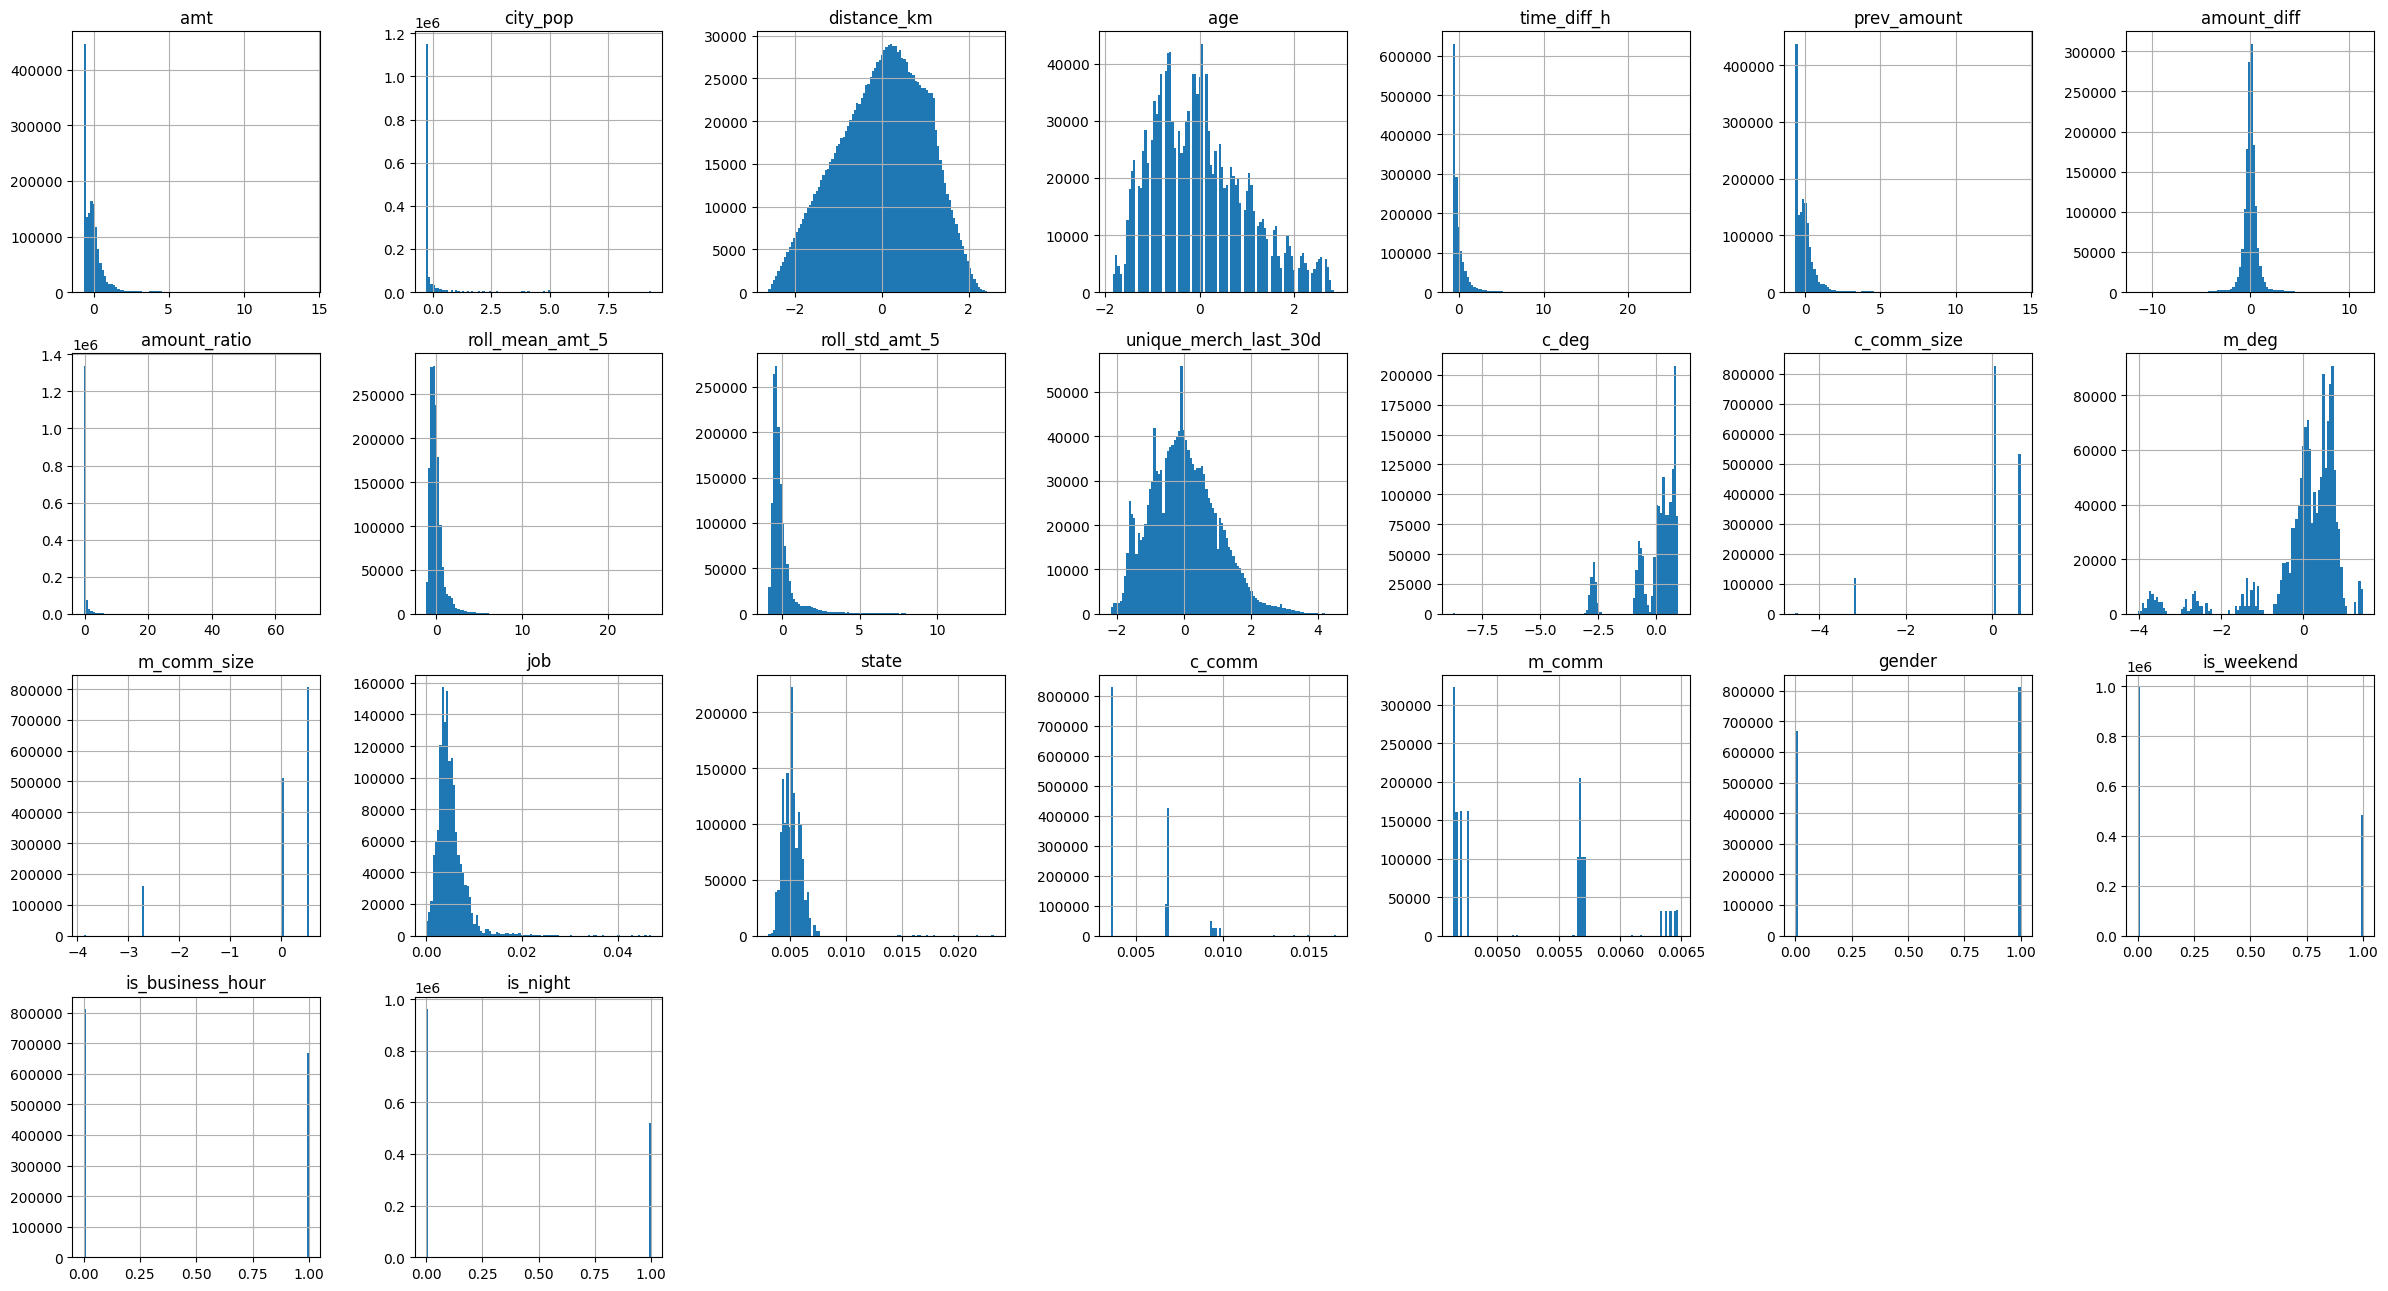

In [29]:
training_df[
    [
        col
        for col in ALL_USED_COLUMNS
        if not col.startswith("category_")
        and not col.startswith("dayofweek_")
        and not col.startswith("emb_")
        and not col.startswith("month_")
        and not col.startswith("hour_")
    ]
].hist(layout=(5, 7), figsize=(24, 16), sharex=False, sharey=False, bins=100)
plt.tight_layout()
plt.show()

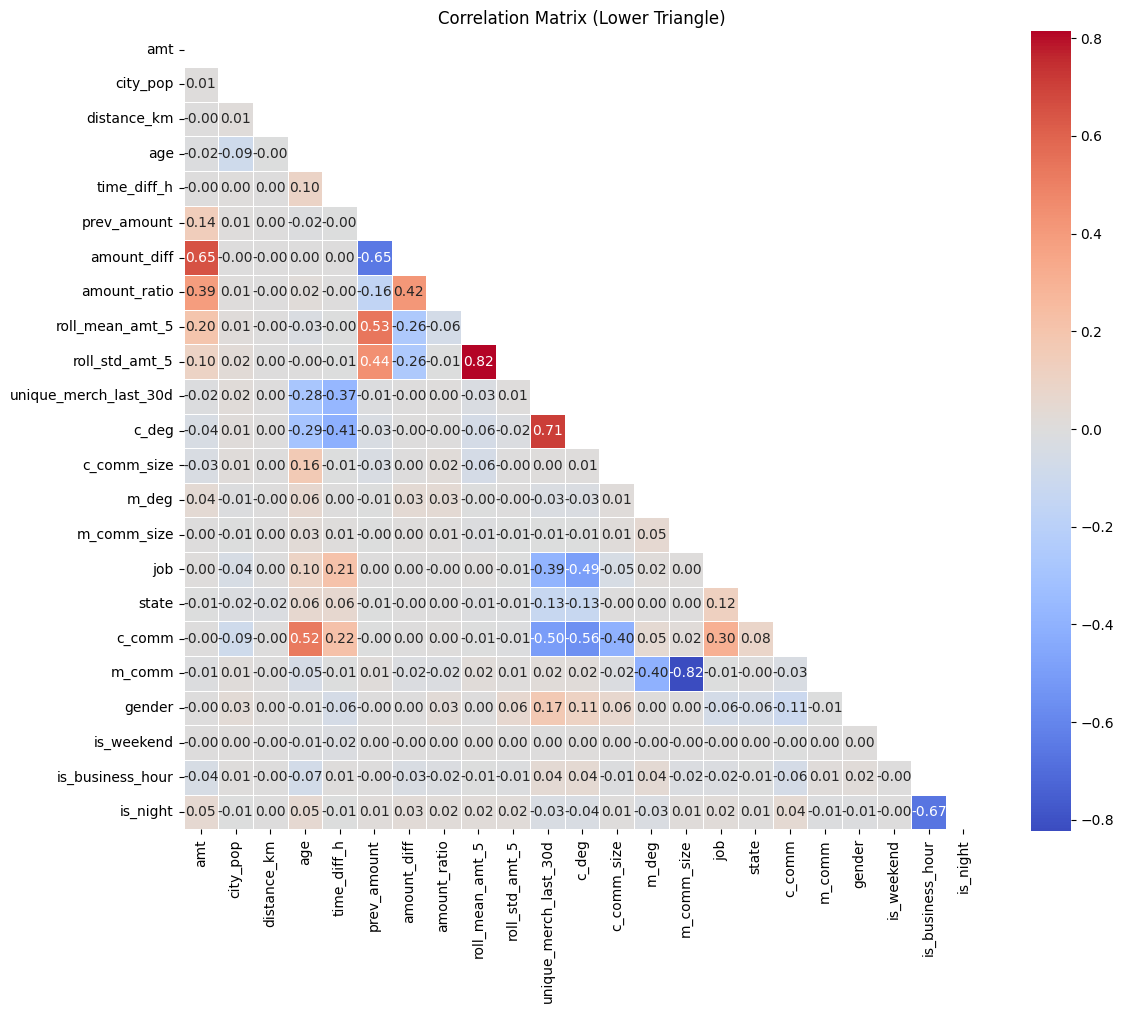

In [30]:
import seaborn as sns

corr = training_df[
    [
        col
        for col in ALL_USED_COLUMNS
        if not col.startswith("category_")
        and not col.startswith("dayofweek_")
        and not col.startswith("emb_")
        and not col.startswith("month_")
        and not col.startswith("hour_")
    ]
].corr()

# Создание маски для верхней треугольной части
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", square=True, linewidths=0.5
)
plt.title("Correlation Matrix (Lower Triangle)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Обучение классических алгоритмов

In [31]:
n_folds = 5

In [32]:
print("GridSearchCV для LogisticRegression...")
param_grid_lr = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "penalty": ["l2"],
    "solver": ["liblinear"],
}
clf_lr = LogisticRegression(class_weight="balanced", max_iter=1000)

n_trials_lr = (
    len(param_grid_lr["C"])
    * len(param_grid_lr["penalty"])
    * len(param_grid_lr["solver"])
)
gs_lr = GridSearchCV(
    clf_lr, param_grid_lr, scoring="roc_auc", cv=n_folds, n_jobs=-1, verbose=5
)
gs_lr.fit(X_train_processed, y_train)

print(f"Best LR params: {gs_lr.best_params_}")
print(f"Best LR AUC: {gs_lr.best_score_}\n")

GridSearchCV для LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.990 total time=  16.3s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.989 total time=  17.9s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.990 total time=  19.5s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.989 total time=  20.8s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.987 total time=  21.5s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.989 total time=  23.7s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.989 total time=  24.3s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.988 total time=  24.6s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.990 total time=  25.4s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.989 total time=  25.5s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.990 total time=  26.0s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.988 total time=  27.8s
[CV 3/5] EN

In [33]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [50, 100]),
        "depth": trial.suggest_int("depth", 4, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "random_state": 42,
        "verbose": 0,
        "devices": "7",
        "task_type": "GPU",
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(
        model, X_train_processed, y_train, cv=n_folds, scoring="roc_auc", n_jobs=1
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, show_progress_bar=True, timeout=600)
best_params_cb_no_graph = study.best_params.copy()

best_cb_model_cb_no_graph = CatBoostClassifier(**best_params_cb_no_graph)
best_cb_model_cb_no_graph.fit(
    X_train_processed, y_train, eval_set=(X_test_processed, y_test), verbose=0
)

print(f"Best Optuna params: {study.best_params}")
print(f"Best Optuna AUC:    {study.best_value:.4f}")

[I 2025-05-25 18:53:41,453] A new study created in memory with name: no-name-4b992a3f-3494-434d-ae4a-3787dccc5f00
   0%|          | 00:00/10:00

Best trial: 0. Best value: 0.996687:   19%|█▉        | 01:53/10:00

[I 2025-05-25 18:55:35,112] Trial 0 finished with value: 0.9966866149299204 and parameters: {'iterations': 50, 'depth': 10, 'learning_rate': 0.026668854815379662}. Best is trial 0 with value: 0.9966866149299204.


Best trial: 1. Best value: 0.99761:   38%|███▊      | 03:45/10:00 

[I 2025-05-25 18:57:27,442] Trial 1 finished with value: 0.9976096117762541 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.030901657043771194}. Best is trial 1 with value: 0.9976096117762541.


Best trial: 1. Best value: 0.99761:   56%|█████▋    | 05:37/10:00

[I 2025-05-25 18:59:19,363] Trial 2 finished with value: 0.9968344400899716 and parameters: {'iterations': 50, 'depth': 10, 'learning_rate': 0.030317951750540657}. Best is trial 1 with value: 0.9976096117762541.


Best trial: 3. Best value: 0.998621:   75%|███████▍  | 07:28/10:00

[I 2025-05-25 19:01:10,323] Trial 3 finished with value: 0.9986211047003621 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.0617443781861854}. Best is trial 3 with value: 0.9986211047003621.


Best trial: 3. Best value: 0.998621:   93%|█████████▎| 09:17/10:00

[I 2025-05-25 19:02:58,940] Trial 4 finished with value: 0.9934555902593427 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.020127879514335378}. Best is trial 3 with value: 0.9986211047003621.


Best trial: 3. Best value: 0.998621:  100%|██████████| 11:18/10:00


[I 2025-05-25 19:04:59,995] Trial 5 finished with value: 0.9974488241923535 and parameters: {'iterations': 50, 'depth': 12, 'learning_rate': 0.03577137808562965}. Best is trial 3 with value: 0.9986211047003621.
Best Optuna params: {'iterations': 100, 'depth': 8, 'learning_rate': 0.0617443781861854}
Best Optuna AUC:    0.9986


In [34]:
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [50, 100]),
        "depth": trial.suggest_int("depth", 4, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "random_state": 42,
        "verbose": 0,
        "devices": "5",
        "task_type": "GPU",
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(
        model,
        X_train_processed_graph,
        y_train_graph,
        cv=n_folds,
        scoring="roc_auc",
        n_jobs=1,
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1200, show_progress_bar=True)

best_params_cb_graph = study.best_params.copy()

best_cb_model_cb_graph = CatBoostClassifier(**best_params_cb_graph)
best_cb_model_cb_graph.fit(
    X_train_processed_graph,
    y_train_graph,
    eval_set=(X_test_processed_graph, y_test_graph),
    verbose=0,
)

print(f"Best Optuna params: {study.best_params}")
print(f"Best Optuna AUC:    {study.best_value:.4f}")

[I 2025-05-25 19:05:34,962] A new study created in memory with name: no-name-12fe932d-1246-4493-942a-39fb0281ca95
Best trial: 0. Best value: 0.997692:   27%|██▋       | 05:19/20:00

[I 2025-05-25 19:10:54,619] Trial 0 finished with value: 0.9976915278878502 and parameters: {'iterations': 100, 'depth': 10, 'learning_rate': 0.025250927368577945}. Best is trial 0 with value: 0.9976915278878502.


Best trial: 0. Best value: 0.997692:   55%|█████▍    | 10:59/20:00

[I 2025-05-25 19:16:34,090] Trial 1 finished with value: 0.9969975333576626 and parameters: {'iterations': 100, 'depth': 12, 'learning_rate': 0.014430960048073217}. Best is trial 0 with value: 0.9976915278878502.


Best trial: 0. Best value: 0.997692:   80%|████████  | 16:04/20:00

[I 2025-05-25 19:21:39,711] Trial 2 finished with value: 0.996273284405882 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.05787931121216207}. Best is trial 0 with value: 0.9976915278878502.


Best trial: 0. Best value: 0.997692:  100%|██████████| 21:04/20:00


[I 2025-05-25 19:26:39,603] Trial 3 finished with value: 0.9906926150586944 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.014164880544753723}. Best is trial 0 with value: 0.9976915278878502.
Best Optuna params: {'iterations': 100, 'depth': 10, 'learning_rate': 0.025250927368577945}
Best Optuna AUC:    0.9977


# GNN

In [35]:
prep = FraudDataPreprocessor(gnn_prepare=True)
X_train_processed_gnn, X_test_processed_gnn, y_train_gnn, y_test_gnn = (
    prep.fit_transform(df_feat)
)
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


Удаление идентификационных колонок (cc_num и merchant), они были нужно, чтобы создать датафреймы, из которых позднее будет создаваться граф

In [36]:
X_train_processed_gnn = np.delete(X_train_processed_gnn, [-1, -2], axis=1)
X_test_processed_gnn = np.delete(X_test_processed_gnn, [-1, -2], axis=1)


Из-за наличия текстовой колонки "сломались" типы, возвращаем обратно к числовым

In [37]:
obj_cols = training_df.select_dtypes(include="object").columns.tolist()
cat_cols = training_df.select_dtypes(include="category").columns.tolist()
obj_cols.remove("merchant")

for c in obj_cols + cat_cols:
    training_df[c] = pd.to_numeric(training_df[c], errors="coerce")

training_df[obj_cols] = training_df[obj_cols].fillna(0)

In [38]:
obj_cols = test_df.select_dtypes(include="object").columns.tolist()
cat_cols = test_df.select_dtypes(include="category").columns.tolist()
obj_cols.remove("merchant")

for c in obj_cols + cat_cols:
    test_df[c] = pd.to_numeric(test_df[c], errors="coerce")

test_df[obj_cols] = test_df[obj_cols].fillna(0)

In [39]:
training_df["is_fraud"] = y_train_gnn.values
test_df["is_fraud"] = y_test.values

Функция ниже - приведение имеющихся данных в необходимый PyTorch формат: индексация узлов и ребер, разбиение фичей на узловые и реберные, а также подготовка к будущему ансамблированию в виду subtrain маски

In [40]:
import torch
from torch_geometric.data import Data


def prepare_edge_gnn_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    node_feat_cols: list[str],
    edge_feat_cols: list[str],
    node_id_cols: tuple[str, str] = ("cc_num", "merchant"),
    target_col: str = "is_fraud",
) -> tuple[Data, Data]:
    # ---- индексация узлов по объединённому df ----
    df_all = pd.concat([df_train, df_test], ignore_index=True)
    left_name, right_name = node_id_cols
    left_ids = df_all[left_name].unique()
    right_ids = df_all[right_name].unique()
    cc2idx = {cc: i for i, cc in enumerate(left_ids)}
    m2idx = {m: i + len(left_ids) for i, m in enumerate(right_ids)}
    num_nodes = len(left_ids) + len(right_ids)

    # ---- node feature matrix x ----

    x = torch.zeros(num_nodes, len(node_feat_cols), dtype=torch.float64)
    node_df = (
        df_all[[left_name] + node_feat_cols]
        .drop_duplicates(left_name)
        .set_index(left_name)[node_feat_cols]
    )
    for node_id, row in node_df.iterrows():
        x[cc2idx[node_id]] = torch.tensor(row.values, dtype=torch.float64)

    # ---- вспомогательная функция ----
    def build_data(df: pd.DataFrame, is_train: bool = True) -> Data:
        src = df[left_name].map(cc2idx).to_numpy()
        dst = df[right_name].map(m2idx).to_numpy()
        edge_index = torch.tensor([src, dst], dtype=torch.long)
        edge_attr = torch.tensor(df[edge_feat_cols].values, dtype=torch.float64)
        y_edge = torch.tensor(df[target_col].values, dtype=torch.float64)

        data = Data(
            num_nodes=num_nodes,
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y_edge=y_edge,
        )
        if is_train:
            data.train_mask = torch.ones(len(df), dtype=torch.bool)
        else:
            data.test_mask = torch.ones(len(df), dtype=torch.bool)
        return data

    data_train = build_data(df_train, is_train=True)
    data_test = build_data(df_test, is_train=False)

    idx_all = np.where(data_train.train_mask.cpu())[0]
    idx_subtrain, idx_val = train_test_split(
        idx_all,
        test_size=0.20,
        stratify=data_train.y_edge[idx_all].cpu().numpy(),
        random_state=42,
    )

    data_train.subtrain_mask = torch.zeros(data_train.num_edges, dtype=torch.bool)
    data_train.val_mask = torch.zeros(data_train.num_edges, dtype=torch.bool)
    data_train.subtrain_mask[idx_subtrain] = True
    data_train.val_mask[idx_val] = True

    return data_train, data_test, idx_subtrain, idx_val

In [41]:
def expand_cols(short_list: list[str], all_cols: list[str]) -> list[str]:
    expanded = []
    for base in short_list:
        if base in all_cols:
            expanded.append(base)
        else:
            expanded.extend([c for c in all_cols if c.startswith(f"{base}_")])
    return expanded


# --- 2. базовые «шорт-листы» ---------------------------------------------
node_base = ["age", "city_pop", "job", "state", "gender"]
edge_base = [
    "amt",
    "prev_amount",
    "amount_diff",
    "amount_ratio",
    "roll_mean_amt_5",
    "roll_std_amt_5",
    "time_diff_h",
    "dayofweek",
    "hour",
    "month",
    "is_night",
    "is_business_hour",
    "is_weekend",
    "unique_merch_last_30d",
    "category",
    "distance_km",
]


node_feats = expand_cols(node_base, ALL_USED_COLUMNS)
edge_feats = expand_cols(edge_base, ALL_USED_COLUMNS)

In [42]:
data_train, data_test, idx_subtrain, idx_val = prepare_edge_gnn_data(
    df_train=training_df,
    df_test=test_df,
    node_id_cols=("cc_num", "merchant"),
    node_feat_cols=node_feats,
    edge_feat_cols=edge_feats,
    target_col="is_fraud",
)

/tmp/ipykernel_4045336/1141522720.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([src, dst], dtype=torch.long)


In [43]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
)
from torch_geometric.nn import GINEConv


# TODO: сделать сеть глубже (на улучшении качества)
class EdgeGNN(torch.nn.Module):
    def __init__(self, in_feats, edge_feats, hidden=64):
        super().__init__()

        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_feats, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
        )
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
        )

        # ключ – edge_dim=edge_feats !
        self.conv1 = GINEConv(nn1, edge_dim=edge_feats)
        self.conv2 = GINEConv(nn2, edge_dim=edge_feats)

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden + edge_feats, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 1),
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        src, _ = edge_index
        h_edge = torch.cat([x[src], edge_attr], dim=1)
        return self.edge_mlp(h_edge).view(-1)

In [44]:
in_feats = data_train.x.size(1)
edge_feats_size = data_train.edge_attr.size(1)
model = EdgeGNN(in_feats, edge_feats_size, hidden=64)
model = model.double().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# class-imbalance: pos_weight = N_neg / N_pos
y_train_gnn_masked = data_train.y_edge[data_train.train_mask]
pos = int(y_train.sum())
neg = int(len(y_train) - pos)

pos_weight = torch.tensor((neg / pos) * 10, dtype=torch.float, device=DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()

In [45]:
def train_epoch(data):
    model.train()
    optimizer.zero_grad()

    out = model(
        data.x.to(DEVICE), data.edge_index.to(DEVICE), data.edge_attr.to(DEVICE)
    )

    loss = criterion(
        out[data.subtrain_mask], data.y_edge[data.subtrain_mask].to(DEVICE)
    )
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def evaluate(data, mask_name="val_mask"):
    model.eval()

    logits = model(
        data.x.to(DEVICE), data.edge_index.to(DEVICE), data.edge_attr.to(DEVICE)
    )

    mask = getattr(data, mask_name)
    y_true = data.y_edge[mask].cpu().numpy()
    y_prob = torch.sigmoid(logits[mask]).cpu().numpy()

    roc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    return roc, ap

In [46]:
n_epochs = 500
best_auc = 0
patience = 15
patience_cnt = 0
best_state = None

pbar = tqdm(range(1, n_epochs + 1), desc="Epochs")

for epoch in pbar:
    loss = train_epoch(data_train)

    if epoch % 2 == 0:
        auc, ap = evaluate(data_train)
        pbar.set_postfix(
            epoch=f"{epoch:03d}",
            loss=f"{loss:.4f}",
            auc=f"{auc:.4f}",
            ap=f"{ap:.4f}",
            refresh=True,
        )

        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print("Early stop.")
                break


model.load_state_dict(best_state)
torch.save(model.state_dict(), "edge_gnn_best.pt")

Epochs: 100%|██████████| 500/500 [01:48<00:00,  4.62it/s, ap=0.7429, auc=0.9757, epoch=500, loss=0.0103]


## Подготовка к ансамблевому использованию GNN и бустинга

Необходимо научиться переводить данные, хранящиеся в PyTorch датасете в тот же вид, в котором их будет принимать бустинг, то есть в np.ndarray, а также убедиться, что это - одни и те же данные.

In [47]:
import numpy as np
import pandas as pd

if "cc_num" in ALL_USED_COLUMNS:
    ALL_USED_COLUMNS.remove("cc_num")
if "merchant" in ALL_USED_COLUMNS:
    ALL_USED_COLUMNS.remove("merchant")


def convert_from_torch(data):
    global ALL_USED_COLUMNS
    src_indices, _ = data.edge_index

    src_np = src_indices.numpy()
    src_feats_np = data.x[src_np].numpy()
    edge_feats_np = data.edge_attr.numpy()

    cols = [f"{n}" for n in node_feats] + edge_feats

    all_feats = np.hstack([src_feats_np, edge_feats_np])
    prepared_to_ensemble_df = pd.DataFrame(all_feats, columns=cols)

    prepared_to_ensemble_df = prepared_to_ensemble_df[ALL_USED_COLUMNS]

    return prepared_to_ensemble_df


prepared_to_ensemble_df = convert_from_torch(data_test)

Проверим, что данные совпадают и выведем колонки, в которых результаты не совпали

In [48]:
comp_result = pd.DataFrame(
    prepared_to_ensemble_df.to_numpy() == X_test_processed_gnn
).all()
prepared_to_ensemble_df.columns[list(comp_result[~comp_result].index)]

Index(['age', 'job', 'state'], dtype='object')

Можно заметить, что полученные данные отличаются от подготовленных ранее по возрасту, а также колонкам, помеченным ранее, как высококардинальные. Это связано с тем, что каждый держатель карты добавлялся в граф единожды, а высококардинальные фичи имеют разные значения, так как было использовано OOF-кодирование. Возраст же отлчиается, потому что данные предоставлены за год и возраст держателей карт за год, очевидно, изменился.

In [49]:
X_train_gnn = convert_from_torch(data_train).to_numpy()
X_test_gnn = convert_from_torch(data_test).to_numpy()

## Обучение ансамбля

In [50]:
if not isinstance(y_train_gnn, np.ndarray):
    y_train_gnn = y_train_gnn.to_numpy()

X_subtrain_gnn = X_train_gnn[idx_subtrain]
y_subtrain_gnn = y_train_gnn[idx_subtrain]

X_val_gnn = X_train_gnn[idx_val]
y_val_gnn = y_train_gnn[idx_val]

In [51]:
boosting_ensemble_classifier = CatBoostClassifier(
    verbose=20,
    random_state=42,
    depth=10,
    iterations=250,
    learning_rate=0.1,
    eval_metric="F:beta=2",
    task_type="GPU",
    devices="7",
)

boosting_ensemble_classifier.fit(X_subtrain_gnn, y_subtrain_gnn)
print(f"  Best CB AUC: {boosting_ensemble_classifier.get_best_score()}")

Default metric period is 5 because F is/are not implemented for GPU
Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6909608	total: 24.9ms	remaining: 6.2s
20:	learn: 0.8432483	total: 510ms	remaining: 5.56s
40:	learn: 0.8824605	total: 945ms	remaining: 4.82s
60:	learn: 0.9130220	total: 1.38s	remaining: 4.28s
80:	learn: 0.9304505	total: 1.82s	remaining: 3.79s
100:	learn: 0.9427372	total: 2.26s	remaining: 3.33s
120:	learn: 0.9498854	total: 2.69s	remaining: 2.87s
140:	learn: 0.9563682	total: 3.14s	remaining: 2.42s
160:	learn: 0.9628638	total: 3.56s	remaining: 1.97s
180:	learn: 0.9697671	total: 4s	remaining: 1.52s
200:	learn: 0.9745569	total: 4.44s	remaining: 1.08s
220:	learn: 0.9770789	total: 4.88s	remaining: 640ms
240:	learn: 0.9804464	total: 5.31s	remaining: 198ms
249:	learn: 0.9812309	total: 5.51s	remaining: 0us
  Best CB AUC: {'learn': {'Logloss': 0.000709054783534051, 'F:beta=2': 0.9812308893370634}}


In [52]:
with torch.no_grad():
    logits_val = model(
        data_train.x.to(DEVICE),
        data_train.edge_index.to(DEVICE),
        data_train.edge_attr.to(DEVICE),
    )
p_gnn_val = torch.sigmoid(logits_val[data_train.val_mask]).cpu().numpy()

In [53]:
p_cb_val = boosting_ensemble_classifier.predict_proba(X_val_gnn)[:, 1]

In [54]:
from sklearn.linear_model import LogisticRegression

X_meta_val = np.column_stack([p_gnn_val, p_cb_val])

meta = LogisticRegression(max_iter=1000, class_weight="balanced")
meta.fit(X_meta_val, y_val_gnn)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Validation

In [55]:
import numpy as np
from sklearn.metrics import (
    fbeta_score,
    precision_score,
    recall_score,
)


def _best_threshold_fbeta(
    y_true: np.ndarray, y_prob: np.ndarray, beta: float = 2.0, tau: float | None = None
):
    order = np.argsort(-y_prob)
    y_sorted = y_true[order]
    p_sorted = y_prob[order]

    tp = np.cumsum(y_sorted)
    fp = np.cumsum(1 - y_sorted)
    fn = tp[-1] - tp

    beta2 = beta * beta
    fbeta = (1 + beta2) * tp / ((1 + beta2) * tp + beta2 * fn + fp)

    i_best = int(np.nanargmax(fbeta))
    tau_best = p_sorted[i_best] if not tau else tau
    return tau_best, fbeta[i_best]


def perform_analysis(
    y_true,
    y_prob,
    beta_for_opt: float = 2.0,
    verbose: bool = True,
    tau: float | None = None,
):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob, dtype=float)

    tau_opt, best_fbeta = _best_threshold_fbeta(
        y_true, y_prob, beta=beta_for_opt, tau=tau
    )

    y_pred = (y_prob >= tau_opt).astype(int)

    f2 = fbeta_score(y_true, y_pred, beta=2)
    f1 = fbeta_score(y_true, y_pred, beta=1)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    if verbose:
        print(f"Optimal threshold (beta={beta_for_opt}) : {tau_opt:.4f}")
        print(f"F{beta_for_opt:.0f}-score (at τ_opt)  : {best_fbeta:.4f}")
        print(f"F2-score               : {f2:.4f}")
        print(f"F1-score               : {f1:.4f}")
        print(f"ROC AUC                : {roc_auc:.4f}")
        print(f"Recall                 : {recall:.4f}")
        print(f"Precision              : {precision:.4f}")

    return (
        {
            "threshold": tau_opt,
            f"F{int(beta_for_opt)}": best_fbeta,
            "F2": f2,
            "F1": f1,
            "ROC_AUC": roc_auc,
            "Recall": recall,
            "Precision": precision,
        }
        if not verbose
        else None
    )

## Логистическая регрессия

In [56]:
lr_result_proba = gs_lr.predict_proba(X_test_processed)[:, 1]
perform_analysis(y_test, lr_result_proba)

Optimal threshold (beta=2.0) : 0.9732
F2-score (at τ_opt)  : 0.6830
F2-score               : 0.6830
F1-score               : 0.6050
ROC AUC                : 0.9871
Recall                 : 0.7472
Precision              : 0.5083


## Бустинг без графовых фичей

In [57]:
boosting_no_graph_result_proba = best_cb_model_cb_no_graph.predict_proba(
    X_test_processed
)[:, 1]

perform_analysis(y_test, boosting_no_graph_result_proba)

Optimal threshold (beta=2.0) : 0.1504
F2-score (at τ_opt)  : 0.9085
F2-score               : 0.9085
F1-score               : 0.8901
ROC AUC                : 0.9981
Recall                 : 0.9212
Precision              : 0.8610


## Бустинг с графовыми фичами

In [58]:
boosting_with_graph_result_proba = best_cb_model_cb_graph.predict_proba(
    X_test_processed_graph
)[:, 1]

perform_analysis(y_test_graph, boosting_with_graph_result_proba)

Optimal threshold (beta=2.0) : 0.1601
F2-score (at τ_opt)  : 0.8903
F2-score               : 0.8903
F1-score               : 0.8753
ROC AUC                : 0.9971
Recall                 : 0.9005
Precision              : 0.8515


## GNN

In [59]:
with torch.no_grad():
    model.eval()
    logits = model(
        data_test.x.to(DEVICE),
        data_test.edge_index.to(DEVICE),
        data_test.edge_attr.to(DEVICE),
    )
    y_prob_gnn = torch.sigmoid(logits[data_test.test_mask]).cpu().numpy()

perform_analysis(y_test_gnn, y_prob_gnn)


Optimal threshold (beta=2.0) : 0.1762
F2-score (at τ_opt)  : 0.6832
F2-score               : 0.6832
F1-score               : 0.6790
ROC AUC                : 0.9742
Recall                 : 0.6860
Precision              : 0.6721


## GNN + бустинг

In [60]:
boosting_ensemble_classifier_probs = boosting_ensemble_classifier.predict_proba(
    X_test_gnn
)[:, 1]

X_meta_test = np.column_stack([y_prob_gnn, boosting_ensemble_classifier_probs])

y_prob_ensemble = meta.predict_proba(X_meta_test)[:, 1]

perform_analysis(y_test_gnn, y_prob_ensemble)


Optimal threshold (beta=2.0) : 0.9986
F2-score (at τ_opt)  : 0.9426
F2-score               : 0.9426
F1-score               : 0.9344
ROC AUC                : 0.9993
Recall                 : 0.9482
Precision              : 0.9210


In [61]:
perform_analysis(y_test_gnn, y_prob_ensemble, tau=0.9)


Optimal threshold (beta=2.0) : 0.9000
F2-score (at τ_opt)  : 0.9426
F2-score               : 0.9393
F1-score               : 0.9111
ROC AUC                : 0.9993
Recall                 : 0.9591
Precision              : 0.8678


# Анализ ошибок для GNN + бустинг

In [62]:
print(X_test_gnn.shape)
print(y_test_gnn.shape)
print(y_prob_ensemble.shape)

(370099, 74)
(370099,)
(370099,)


In [108]:
df = pd.DataFrame(
    np.hstack([X_test_gnn, np.atleast_2d(y_test_gnn).T, np.atleast_2d(y_prob_ensemble).T]),
    columns=[*ALL_USED_COLUMNS, "y_true", "y_pred"],
)


In [ ]:
df["y_true"] = df["y_true"].astype(int)
df["y_pred"] = df["y_pred"].apply(lambda x: int(x > 0.9)) # Используем подобранный порог

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(df.y_true, df.y_pred, digits=3))
print("\nConfusion matrix (raw counts):")
print(confusion_matrix(df.y_true, df.y_pred))

def label_row(row):
    if row.y_true == 1 and row.y_pred == 1:
        return "TP"
    elif row.y_true == 0 and row.y_pred == 1:
        return "FP"
    elif row.y_true == 1 and row.y_pred == 0:
        return "FN"
    else:
        return "TN"


df["err_type"] = df.apply(label_row, axis=1)

num_cols = ['amt', 'city_pop', 'distance_km', 'age', 'time_diff_h',
            'prev_amount', 'amount_diff', 'amount_ratio',
            'roll_mean_amt_5', 'roll_std_amt_5', 'unique_merch_last_30d']

mean_tbl = df.groupby('err_type')[num_cols].mean()

diff_tbl = pd.DataFrame({
    'Δ_FP-TP': mean_tbl.loc['FP'] - mean_tbl.loc['TP'],
    'Δ_FN-TN': mean_tbl.loc['FN'] - mean_tbl.loc['TN'],
}).T.round(3)

display(diff_tbl.T.sort_values('Δ_FP-TP', key=abs, ascending=False).style.background_gradient(cmap="Blues", axis=None))


              precision    recall  f1-score   support

           0      1.000     0.999     1.000    368169
           1      0.868     0.959     0.911      1930

    accuracy                          0.999    370099
   macro avg      0.934     0.979     0.955    370099
weighted avg      0.999     0.999     0.999    370099


Confusion matrix (raw counts):
[[367887    282]
 [    79   1851]]


,Δ_FP-TP,Δ_FN-TN
roll_mean_amt_5,-2.581000,1.622000
prev_amount,-1.586000,0.640000
amt,-1.005000,0.983000
amount_ratio,0.684000,0.610000
amount_diff,0.440000,0.263000
time_diff_h,0.349000,0.211000
unique_merch_last_30d,0.304000,-0.302000
roll_std_amt_5,-0.273000,1.565000
age,-0.226000,0.163000
city_pop,-0.068000,0.069000


Таблица выше отображает разницу между средними значениями для колонки по типу ответа (TP, TN, FP, FN). Читать это следует так: </br> Если средний amt у FP выше, чем у TP → модель чаще ошибается на крупных суммах (ложные срабатывания).

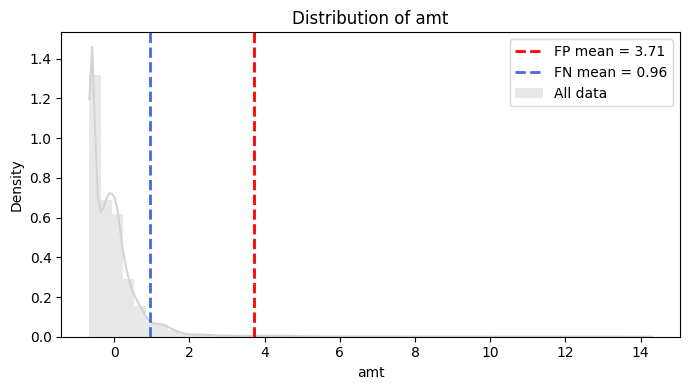

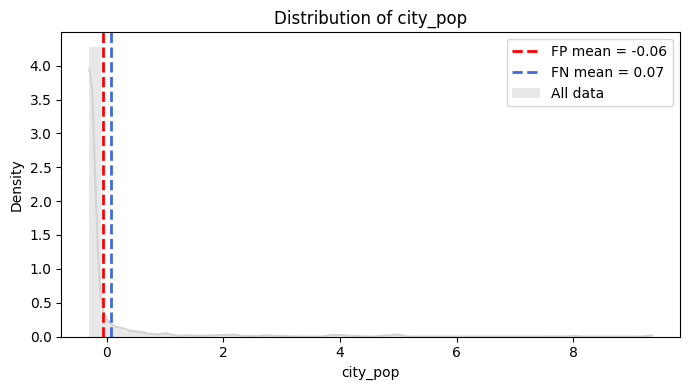

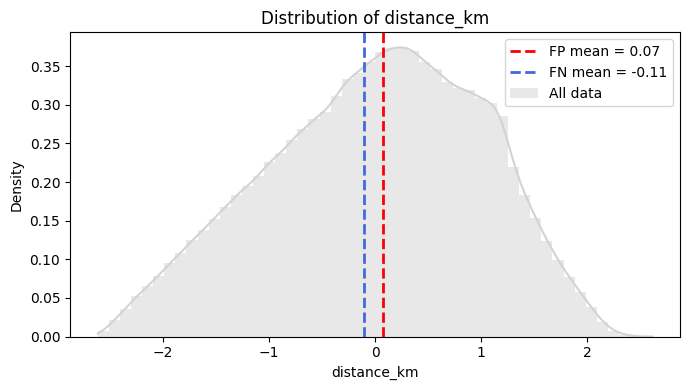

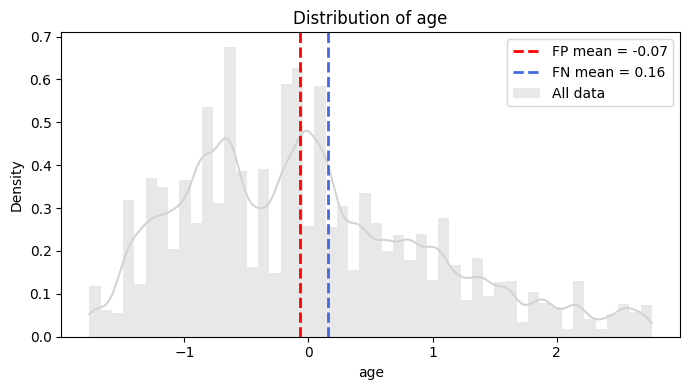

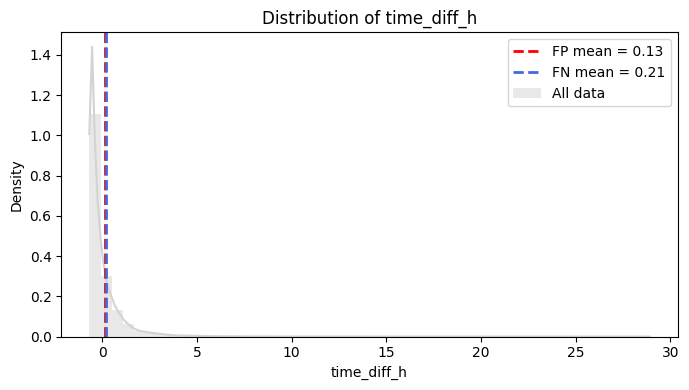

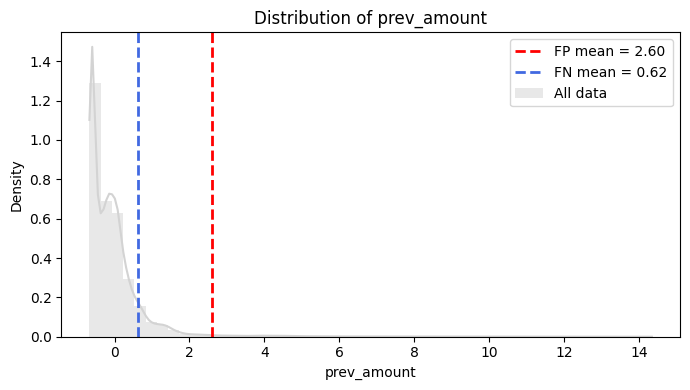

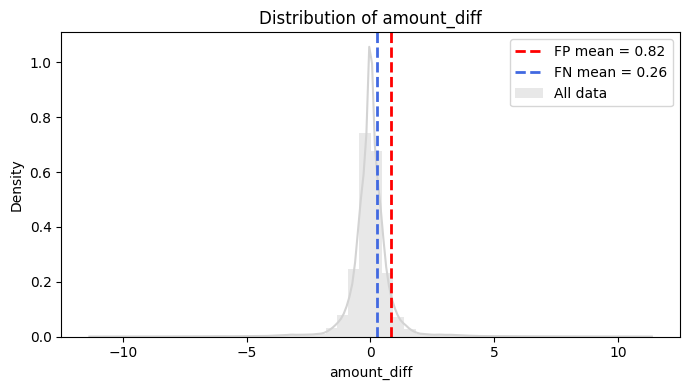

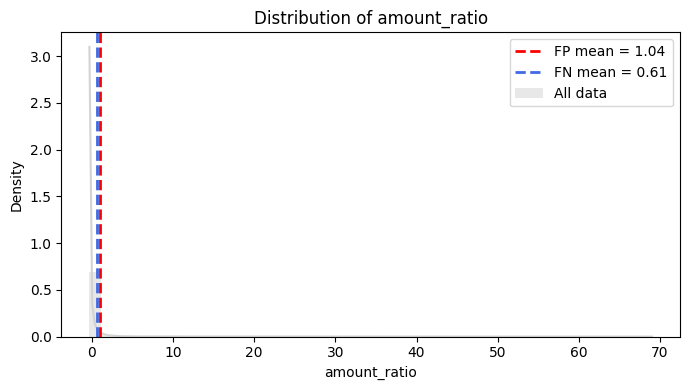

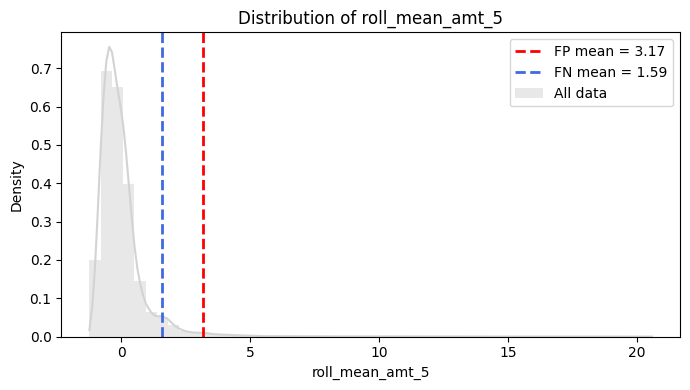

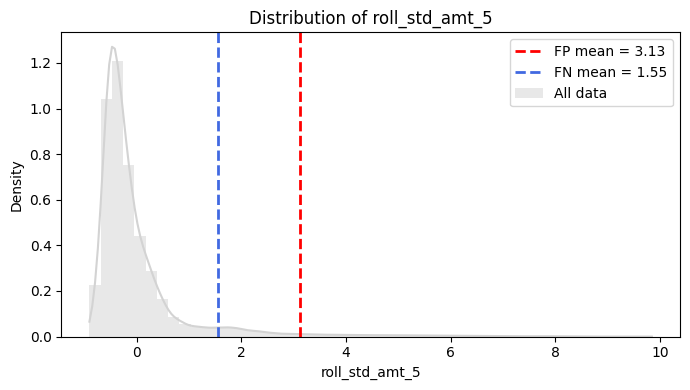

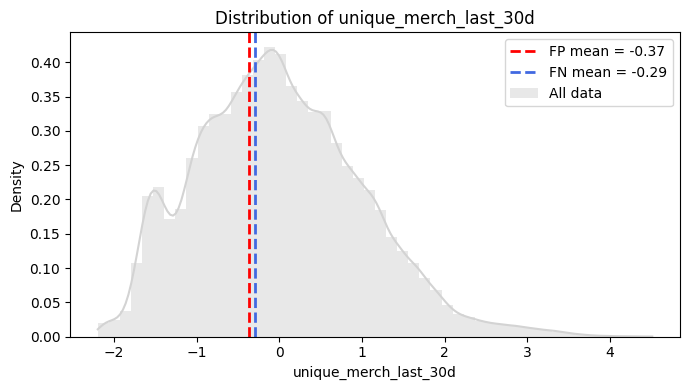

In [ ]:
def plot_feature_with_error_means(df, col):
    plt.figure(figsize=(7, 4))
    
    sns.histplot(df[col].dropna(), bins=50, kde=True, stat="density",
                 color='lightgrey', edgecolor='none', label='All data')
    
    err_colors = {'FP': 'red', 'FN': 'royalblue'}
    for err, color in err_colors.items():
        subset = df.loc[df['err_type'] == err, col].dropna()
        if subset.empty:
            continue
        mu = subset.mean()
        plt.axvline(mu, color=color, linestyle='--',
                    linewidth=2, label=f'{err} mean = {mu:.2f}')
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

for col in num_cols:
    plot_feature_with_error_means(df, col)

## Вывод по анализу графиков

| № | Признак | Что видно на графике | Вывод / гипотеза | Что можно попробовать |
|---|---------|----------------------|------------------|-----------------------|
| 1 | **distance_km** | FP-среднее (+0.07) правее пика, FN (-0.11) левее. | Ложные тревоги, когда клиент **чуть дальше** обычного; пропуски, когда «совсем рядом». | |
| 2 | **amt** | Правый тяжёлый хвост; FP-среднее (3.7) далеко в хвосте, FN (1.0) ближе к центру. | **Крупные суммы ⇒ FP**, мелкие / средние ⇒ FN. | Логарифм суммы, бины, сегментация «high-amount», адаптивные cut-off. |
| 3 | **city_pop** | Экспоненциальное слева; FP (-0.06) в малых городах, FN (+0.07) в более крупных. | Модель переоценивает риск «деревень», недооценивает мегаполисы. | Признак rural/urban, плотность, отдельно обучить региональные модели. |
| 4 | **age (z-score)** | FP-среднее (-0.07) < 0, FN (+0.16) > 0. | **Возраст ниже среднего → FP**, выше среднего → FN. | Добавить age-bands, sample weight старших. |
| 5 | **time_diff_h** | Распределение сосредоточено < 1 ч; FP и FN близки, но FN чуть правее. | Временной разрыв слабый маркер; FN при чуть больших паузах. | |
| 6 | **prev_amount** | Та же картина, что amt; FP (2.6) в хвосте, FN (0.6) ближе к центру. | Большая предыдущая сумма вызывает FP. | Нормировать на среднем клиента, бины, признаки «relative_prev». |
| 7 | **amount_diff** | FP (0.82) положительнее, FN (0.26) ближе к 0. | Большой положительный скачок ⇒ FP. | Использовать abs-diff, лог-diff, взаимодействие с category. |
| 8 | **amount_ratio** | FP (1.04) > FN (0.61); обе линии около 0, но FP правее. | Высокий ratio «тек/пред» ведёт к ложным тревогам. | Лог-ratio, клиппинг экстремумов, защитный порог. |
| 9 | **roll_mean_amt_5** | FP-среднее (3.17) почти вдвое > FN (1.59). | Повышенный скользящий средний чек ⇒ FP. | Центрировать на клиенте, использовать median, признак тренда. |
|10 | **roll_std_amt_5** | FP (3.13) > FN (1.55). | Большая внутрисерийная дисперсия → FP. | Нормированная std / CV, сглаживание, порог на variance. |
|11 | **unique_merch_last_30d** | Распределение симметричнее других; FP-среднее (-0.37) **слегка левее** FN (-0.29), обе левее нуля. | И FP, и FN происходят у клиентов, посетивших **меньше разных мерчантов, чем средний**; FP чуть более смещены в ещё меньшую уникальность. | Добавить бины: `≤ N` / `> N` уникальных мерчантов; признак «доля новых мерчантов за 30 дней»; применить скоринг «новизны поведения» вместо голого z-score. |

In [120]:

cat_single = ["job", "state", "gender"]


def cat_report(col):
    grp = df.groupby([col, "err_type"]).size().unstack(fill_value=0)
    grp["total"] = grp.sum(axis=1)
    grp["FP_rate"] = grp["FP"] / grp["total"]
    grp["FN_rate"] = grp["FN"] / grp["total"]
    return grp[grp.total > 100].sort_values("FP_rate", ascending=False)


cat_reports = {c: cat_report(c) for c in cat_single}


def recover_prefix(prefix):
    cols = [c for c in df.columns if c.startswith(prefix)]
    tmp = (
        df[cols]
        .idxmax(axis=1) 
        .str.replace(prefix, "", regex=False)
    )
    return tmp.where(df[cols].sum(axis=1) > 0, np.nan)  


df["dayofweek"] = recover_prefix("dayofweek_")
df["hour"] = recover_prefix("hour_")
df["month"] = recover_prefix("month_")
df["category"] = recover_prefix("category_")

for col in ["dayofweek", "hour", "month", "category"]:
    cat_reports[col] = cat_report(col)


In [119]:
print("\n=== Категориальные с самыми высокими FP_rate ===")
for k, tbl in cat_reports.items():
    print(f"\n>>> {k.upper()}:")
    display(tbl[["FP_rate", "FN_rate", "total"]].sort_values("FP_rate", ascending=False).head(10))


=== Категориальные с самыми высокими FP_rate ===

>>> JOB:


err_type,FP_rate,FN_rate,total
job,,,
0.013374,0.014235,0.000000,281
0.021142,0.013699,0.006849,146
0.007951,0.013514,0.000000,148
0.003984,0.012903,0.000000,155
0.009036,0.012821,0.006410,156
0.005334,0.008475,0.000000,118
0.019694,0.007692,0.000000,130
0.010707,0.007407,0.000000,135
0.004290,0.007353,0.000000,136



>>> STATE:


err_type,FP_rate,FN_rate,total
state,,,
0.005745,0.006873,0.000000,291
0.003868,0.006803,0.000000,294
0.006330,0.006579,0.000000,152
0.005175,0.006452,0.000000,155
0.005343,0.004213,0.000000,712
0.004270,0.003964,0.000991,1009
0.005159,0.003953,0.000000,1012
0.005223,0.003740,0.000000,1337
0.004169,0.003378,0.000000,296



>>> GENDER:


err_type,FP_rate,FN_rate,total
gender,,,
1.0,0.000879,0.000247,202459
0.0,0.000620,0.000173,167640



>>> DAYOFWEEK:


err_type,FP_rate,FN_rate,total
dayofweek,,,
Friday,0.001094,0.000303,42944
Wednesday,0.000866,0.000379,36939
Monday,0.000731,0.000190,73864
Thursday,0.000730,0.000219,41102
Tuesday,0.000725,0.000074,53784
Saturday,0.000722,0.000190,52605
Sunday,0.000610,0.000218,68861



>>> HOUR:


err_type,FP_rate,FN_rate,total
hour,,,
22,0.002916,0.000477,18860
23,0.002315,0.001000,19004
0,0.002145,0.000495,12119
1,0.001957,0.000245,12264
3,0.001317,0.000329,12145
11,0.000826,0.000165,12105
2,0.000739,0.000329,12172
16,0.000639,0.000107,18779
6,0.000580,0.000000,12072



>>> MONTH:


err_type,FP_rate,FN_rate,total
month,,,
2,0.001246,0.000104,19254
1,0.001187,0.000285,21062
11,0.000982,0.000281,28509
3,0.000946,0.000280,28554
10,0.000873,0.000073,27502
7,0.000780,0.000318,34597
12,0.000658,0.000160,56195
8,0.000650,0.000198,35387
5,0.000619,0.000138,29089



>>> CATEGORY:


err_type,FP_rate,FN_rate,total
category,,,
misc_net,0.002815,0.000162,18472
travel,0.001951,0.000621,11275
misc_pos,0.001438,0.000741,22955
shopping_net,0.001378,0.000036,27568
shopping_pos,0.001202,0.000120,33288
health_fitness,0.000824,0.000165,24262
kids_pets,0.000710,0.000247,32409
grocery_net,0.000617,0.000231,12964
personal_care,0.000457,0.000457,26254


## Анализ ошибок по категориальным признакам

FP_rate - доля ложных срабатываний среди всех транзакций этой категории </br>
FN_rate - доля пропущенных операций среди всех танзакций этой категории

Как можно увидеть, по всем категориям значения FP_rate и FN_rate являются незначительными (не более 2%)

# Вывод

Наилучший результат показал комплексный подход, использующий графовую нейронную сеть для классификации ребер, а также градиентный бустинг, выходные вреоятности пропускаются через логистическую регрессию для получения финального результата. Кроме целевой метрики (F2Score), этот алгоритм имеет самый высокий precision, что позволяет достичь поставленных продуктовых целей по уменьшению ложно-положительных срабатываний. В дальнейшей работе планируется использование связки (GNN + CatBoost -> LogisticRegression).

Развернутый анализ ошибок указал на некоторые моменты, которые могут быть учтены при инференсе модели (такие как дополнительные пороги) или при следующих итерациях обучения при развитии платформы (дополнительные признаки)